# Chest Diseases Detection
<hr>

Use Deep Learning to automate the process of detecting and classifying chest diseases in a hospital.

# Background and Business Problem

AI/ML/DL has been revolutionizing healthcare and medicine:
- Medical imagery
- Drug research
- Genome development

Deep learning has been proven to be superior in detecting and classifying disease using imagery data. Skin cancer could be detected more accurately by Deep Learning by dermatologists (2018).
- Human dermatologists detection = 86.6%
- Deep Learning detection = 95%

_Rereference: "Computer learns to detect skin cancer more accurately than doctors". The Guardian, 29 May 2018._


## Case Study

In this case study, we will assume that you work as a __Deep Learning Consultant__.
- You have been hired by a hospital in downtown Toronto and you have been tasked to automate the process of detecting and classifying chest disease and reduce the cost and time of detection.
- The team has collected extensive X-Ray Chest data and they approached you to develop a model that could detect and classify the diseases in less than 1 minute. 
- You have been provided with 133 images that belong to 4 classes:
    - Healthy
    - Covid-19
    - Bacterial Pneumonia
    - Viral Pneumonia

# Import the Libraries and Dataset

- This is a custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray images, and normal person x-ray images. Each class contains 133 images.
- Source:
    - https://github.com/ieee8023/covid-chestxray-dataset
    - https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [13]:
# import all the main libraries
import os
# !pip install opencv-contrib-python
import cv2 # OpenCV
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False

# Display all the columns in pandas without being truncated
pd.options.display.max_columns = None

In [89]:
# Specify training data directory
x_ray_directory = 'Datasets/Dataset'
test_directory = 'Datasets/Test'

# List the folder in the directory
print(os.listdir(x_ray_directory))
print(os.listdir(test_directory))

['0', '1', '2', '3']
['0', '1', '2', '3']


In [22]:
# Use the image generator to generate tensor images form 
# Use 20% of the data for cross-validation

image_generator = ImageDataGenerator( rescale=1./255, validation_split=0.2)

In [27]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

# Our training data
train_generator = image_generator.flow_from_directory(directory=x_ray_directory, 
                                                      batch_size=40, 
                                                      shuffle=True, 
                                                      target_size=(256,256), 
                                                      class_mode = 'categorical',
                                                      subset = 'training')

# Our validation data
validation_generator = image_generator.flow_from_directory(directory=x_ray_directory, 
                                                           batch_size=40, 
                                                           shuffle=True, 
                                                           target_size=(256,256), 
                                                           class_mode = 'categorical',
                                                           subset = 'validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [32]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)
print(train_images.shape)
print(train_labels.shape)
print(train_labels)

(40, 256, 256, 3)
(40, 4)
[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [33]:
# labels Translator 
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

## Visualize Dataset

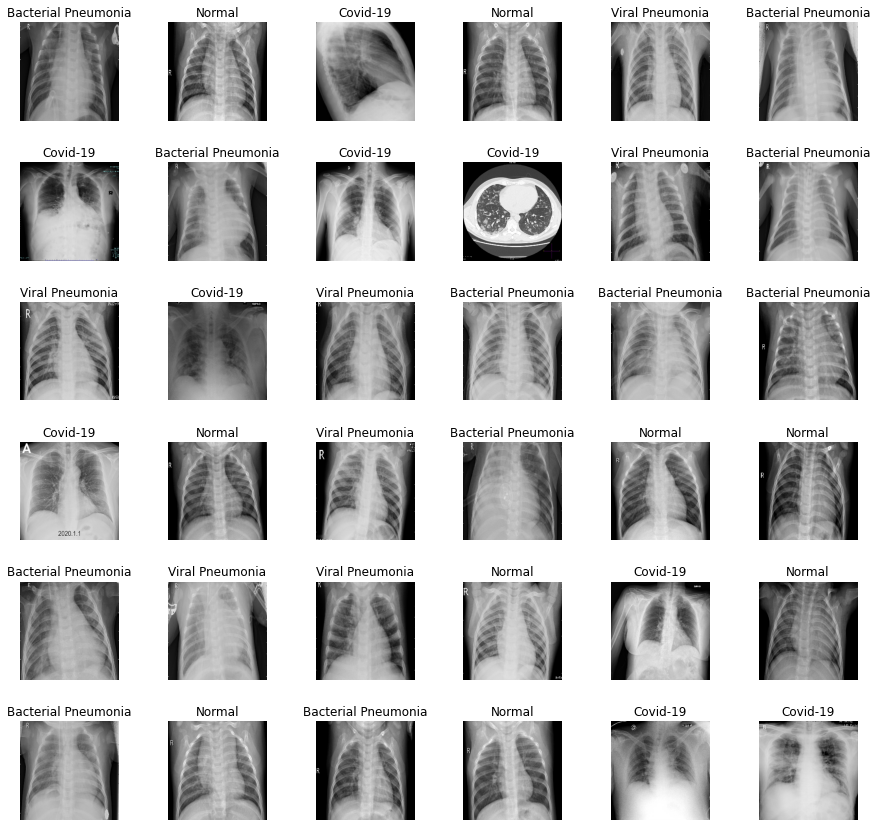

In [58]:
row = 6 
col = 6 

# create a figure and a set of subplots
fig, axes = plt.subplots(row, col, figsize = (15,15))
# flatten the axes, so that it will have 1-D array indexing from 0-35
axes = axes.ravel()

for i in np.arange(0, row*col):
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].imshow(train_images[i])
    axes[i].axis(False)

plt.subplots_adjust(wspace=0.5)

# Model Building

## Convolutional Neural Network

- The __first layers__ are used to extract high level general features.
- The __last couple of layers__ are used to perform classification (on a specific task).
- Local respective fields scan the image first searching for simple shapes such as edges/lines.
- These edges are then picked up by the subsequent layer to form more comples features.

## Deep Learning History

There are many trained off the shelve convolutional neural networks taht are readily available such as:
- LeNet-5 (1998): 7 level convolutional neural network developed by LeCun that works in classifying hand writing numbers.
- AlexNet (2012): offered massive improvement, error reduction form 26% to 15.3%.
- ZFNET (2013): achieved error of 14.8%
- Googlenet/Inception (2014): error reduction to 6.67% whihc is at par with human level accuracy.
- VGGNet (2014)
- ResNet(2015): Residual Neural Network includes 'skip connection' feature and therfore enabled training of 152 layers without vanishing gradient issues. Error of 3.57% which is superior than humans.

Source: https://medium.com/analytics-vidhya/cnns-architecture-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5

## ResNet (Residual Network)

- As CNNs grow deeper, vanishing gradient tend to occur which negatively impact network performance.
- Vanishing gradient problem occurs when the gradient is back-propagated to earlier layers which results in a very small gradient. 
- Residual Neural Network includes "skip connection" feature which enables training of 152 layers without vanishing gradient issues.
- Resnet works by adding "identity mappings" on top of the CNN.
- ImageNet contains 11 million images and 11,000 categories. 
- ImageNet is used to traing ResNet deep network.
<img src='Images/resnet.png' width='400'>

## Transfer Learning

__What is Transfer Learning?__
- Transfer learning is a machine learning technique in which a network that has been trained to perform a specific task is being reused (repurposed) as a starting point for another similar task.
- Transfer learning is widely used since starting from a pre-trained models can dramatically reduce the computational time required if training is performed from scratch.
- "Transfer learning is the improvement of learning in a new task through the transfer of knowledge from a related task that has already been learned" - Transfer learning, Handbook of Research on Machine Learning Applications, 2009.
- In transfer learning, a base (reference) Artificial Neural Network on a base dataset and function is being trained. Then, this trained network weights are then repurposed in a second ANN to be trained on a new dataset and function.
- Transfer learning works really great if the features are general, such that trained weights can effectively repurposed. 
- Intelligence is being transferred from the base network to the newly target network.

<img src='Images/transfer-learning.png' width='800'>

__Why do We Keep the First Layer?__
- The first CNN layers are used to extract high level general features. 
- The last couple of layers are used to perform classification (on a specific task).
- So we copy the first trained layers (based model) and then we add a new custom layers in the output to perform classification on a specific new task.


## Import Model with Pretrained Weights

Let's import the ResNet50 as our base model with the followings criterion:
- use a pre-training model thas been trained on imagenet dataset;
- do not include the top fully connected layer;
- define the input tensor as our input image shape (256 x 256 x 3 ) px.

In [59]:
basemodel = ResNet50( weights='imagenet', include_top=False, input_tensor=Input( shape=(256, 256, 3)))

94773248/94765736 [==============================] - 59s 1us/step


In [60]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [70]:
# Freezing layers in the base model but keeping the last 10 layers trainable
for layer in basemodel.layers[:-10]:
    layer.trainable = False

basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Build and Train the Model

In [121]:
headmodel = basemodel.output
headmodel = AveragePooling2D( pool_size=(4,4))(headmodel)
headmodel = Flatten()(headmodel)
headmodel = Dense( units=128, activation='relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense( units=64, activation='relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense( units=4, activation='softmax')(headmodel)

# Define the model
model = Model( inputs = basemodel.input, outputs = headmodel)

# compilte the model
# lr = 0.001
# model.compile( optimizer=optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['acc'])
model.compile( optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6), loss='categorical_crossentropy', metrics=['acc'])

In [122]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
early_stopping = EarlyStopping(monitor='val_acc', 
                               min_delta=0, 
                               patience=10, 
                               verbose=1,
                               mode='auto', 
                               restore_best_weights=True)

# save the best model with highest validation accuracy
checkpointer = ModelCheckpoint(filepath='weights.h5', 
                               monitor='val_acc', 
                               save_best_only=True, 
                               mode='max')

In [123]:
# Add our data-augmentation parameters to ImageDataGenerator
image_generator = ImageDataGenerator( rescale=1./255, validation_split=0.2)
# train_datagen = ImageDataGenerator(rescale = 1./255.,
#                                      #validation_split=0.2,
#                                      rotation_range = 40,
#                                      width_shift_range = 0.2,
#                                      height_shift_range = 0.2,
#                                      shear_range = 0.2,
#                                      zoom_range = 0.2,
#                                      horizontal_flip = True)

# test_datagen = ImageDataGenerator( rescale=1./255)

# Our training data
train_generator = image_generator.flow_from_directory(directory=x_ray_directory, 
                                                      batch_size=40, 
                                                      shuffle=True, 
                                                      target_size=(256,256), 
                                                      class_mode = 'categorical',
                                                      subset = 'training')

# Our validation data
validation_generator = image_generator.flow_from_directory(directory=x_ray_directory, 
                                                           batch_size=40, 
                                                           shuffle=True, 
                                                           target_size=(256,256), 
                                                           class_mode = 'categorical',
                                                           subset = 'validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [124]:
history = model.fit(x = train_generator, 
                    validation_data=validation_generator, 
                    callbacks=[checkpointer],
                    epochs=500, 
                    verbose=1)

Epoch 1/500
11/11 [==============================] - 78s 7s/step - loss: 1.3845 - acc: 0.3528 - val_loss: 1.1147 - val_acc: 0.5962
Epoch 2/500
11/11 [==============================] - 72s 7s/step - loss: 1.1564 - acc: 0.4673 - val_loss: 1.1721 - val_acc: 0.3365
Epoch 3/500
11/11 [==============================] - 74s 7s/step - loss: 1.0425 - acc: 0.5187 - val_loss: 1.1787 - val_acc: 0.3654
Epoch 4/500
11/11 [==============================] - 71s 6s/step - loss: 1.0054 - acc: 0.5607 - val_loss: 1.3331 - val_acc: 0.2981
Epoch 5/500
11/11 [==============================] - 72s 7s/step - loss: 0.9751 - acc: 0.5748 - val_loss: 1.2345 - val_acc: 0.3365
Epoch 6/500
11/11 [==============================] - 73s 7s/step - loss: 0.9598 - acc: 0.6075 - val_loss: 1.0417 - val_acc: 0.4904
Epoch 7/500
11/11 [==============================] - 72s 7s/step - loss: 0.9182 - acc: 0.6005 - val_loss: 1.0804 - val_acc: 0.4904
Epoch 8/500
11/11 [==============================] - 74s 7s/step - loss: 0.9029 - a

11/11 [==============================] - 78s 7s/step - loss: 0.5844 - acc: 0.7967 - val_loss: 0.8032 - val_acc: 0.7019
Epoch 64/500
11/11 [==============================] - 75s 7s/step - loss: 0.5975 - acc: 0.7710 - val_loss: 0.7831 - val_acc: 0.7308
Epoch 65/500
11/11 [==============================] - 88s 8s/step - loss: 0.6371 - acc: 0.7734 - val_loss: 0.7276 - val_acc: 0.7115
Epoch 66/500
11/11 [==============================] - 77s 7s/step - loss: 0.5896 - acc: 0.7850 - val_loss: 0.7571 - val_acc: 0.7212
Epoch 67/500
11/11 [==============================] - 75s 7s/step - loss: 0.5676 - acc: 0.7804 - val_loss: 0.7364 - val_acc: 0.7019
Epoch 68/500
11/11 [==============================] - 71s 6s/step - loss: 0.6463 - acc: 0.7757 - val_loss: 0.7470 - val_acc: 0.7019
Epoch 69/500
11/11 [==============================] - 70s 6s/step - loss: 0.5818 - acc: 0.7664 - val_loss: 0.8239 - val_acc: 0.6923
Epoch 70/500
11/11 [==============================] - 72s 7s/step - loss: 0.5625 - acc: 0

11/11 [==============================] - 105s 10s/step - loss: 0.4788 - acc: 0.8411 - val_loss: 0.6954 - val_acc: 0.7500
Epoch 125/500
11/11 [==============================] - 105s 10s/step - loss: 0.4785 - acc: 0.8364 - val_loss: 0.8073 - val_acc: 0.6923
Epoch 126/500
11/11 [==============================] - 86s 8s/step - loss: 0.4997 - acc: 0.8341 - val_loss: 0.7295 - val_acc: 0.7115
Epoch 127/500
11/11 [==============================] - 70s 6s/step - loss: 0.4818 - acc: 0.8411 - val_loss: 0.6820 - val_acc: 0.7308
Epoch 128/500
11/11 [==============================] - 70s 6s/step - loss: 0.4992 - acc: 0.8178 - val_loss: 0.6907 - val_acc: 0.7596
Epoch 129/500
11/11 [==============================] - 72s 7s/step - loss: 0.4765 - acc: 0.8411 - val_loss: 0.7114 - val_acc: 0.7500
Epoch 130/500
11/11 [==============================] - 71s 6s/step - loss: 0.4705 - acc: 0.8318 - val_loss: 0.6783 - val_acc: 0.7404
Epoch 131/500
11/11 [==============================] - 70s 6s/step - loss: 0.45

11/11 [==============================] - 71s 6s/step - loss: 0.4092 - acc: 0.8668 - val_loss: 0.9302 - val_acc: 0.7019
Epoch 186/500
11/11 [==============================] - 71s 6s/step - loss: 0.3699 - acc: 0.8879 - val_loss: 0.6811 - val_acc: 0.7692
Epoch 187/500
11/11 [==============================] - 71s 6s/step - loss: 0.4036 - acc: 0.8575 - val_loss: 0.7420 - val_acc: 0.7404
Epoch 188/500
11/11 [==============================] - 71s 6s/step - loss: 0.4013 - acc: 0.8692 - val_loss: 0.6629 - val_acc: 0.7500
Epoch 189/500
11/11 [==============================] - 71s 6s/step - loss: 0.3755 - acc: 0.8785 - val_loss: 0.8711 - val_acc: 0.7404
Epoch 190/500
11/11 [==============================] - 71s 6s/step - loss: 0.3801 - acc: 0.8668 - val_loss: 0.7260 - val_acc: 0.7404
Epoch 191/500
11/11 [==============================] - 71s 6s/step - loss: 0.3864 - acc: 0.8621 - val_loss: 0.7154 - val_acc: 0.7596
Epoch 192/500
11/11 [==============================] - 71s 6s/step - loss: 0.4730 -

Epoch 247/500
11/11 [==============================] - 82s 7s/step - loss: 0.3409 - acc: 0.8855 - val_loss: 0.7051 - val_acc: 0.7788
Epoch 248/500
11/11 [==============================] - 80s 7s/step - loss: 0.3351 - acc: 0.8855 - val_loss: 0.6853 - val_acc: 0.7596
Epoch 249/500
11/11 [==============================] - 74s 7s/step - loss: 0.3659 - acc: 0.8738 - val_loss: 0.6658 - val_acc: 0.7885
Epoch 250/500
11/11 [==============================] - 71s 6s/step - loss: 0.3881 - acc: 0.8808 - val_loss: 0.7583 - val_acc: 0.7788
Epoch 251/500
11/11 [==============================] - 71s 6s/step - loss: 0.3027 - acc: 0.8879 - val_loss: 0.7582 - val_acc: 0.7692
Epoch 252/500
11/11 [==============================] - 80s 7s/step - loss: 0.3157 - acc: 0.9019 - val_loss: 0.8796 - val_acc: 0.7788
Epoch 253/500
11/11 [==============================] - 85s 8s/step - loss: 0.3082 - acc: 0.9042 - val_loss: 0.7910 - val_acc: 0.7981
Epoch 254/500
11/11 [==============================] - 83s 8s/step - 

11/11 [==============================] - 72s 7s/step - loss: 0.3228 - acc: 0.8879 - val_loss: 0.9430 - val_acc: 0.7115
Epoch 309/500
11/11 [==============================] - 70s 6s/step - loss: 0.2761 - acc: 0.9112 - val_loss: 1.3986 - val_acc: 0.7115
Epoch 310/500
11/11 [==============================] - 71s 6s/step - loss: 0.2837 - acc: 0.8995 - val_loss: 0.8545 - val_acc: 0.7596
Epoch 311/500
11/11 [==============================] - 70s 6s/step - loss: 0.2866 - acc: 0.8995 - val_loss: 0.8596 - val_acc: 0.7692
Epoch 312/500
11/11 [==============================] - 71s 6s/step - loss: 0.2801 - acc: 0.8995 - val_loss: 0.8203 - val_acc: 0.7596
Epoch 313/500
11/11 [==============================] - 70s 6s/step - loss: 0.3523 - acc: 0.8808 - val_loss: 0.8137 - val_acc: 0.7596
Epoch 314/500
11/11 [==============================] - 73s 7s/step - loss: 0.2910 - acc: 0.8902 - val_loss: 0.8375 - val_acc: 0.7596
Epoch 315/500
11/11 [==============================] - 72s 7s/step - loss: 0.2817 -

Epoch 370/500
11/11 [==============================] - 83s 8s/step - loss: 0.2603 - acc: 0.8972 - val_loss: 0.9604 - val_acc: 0.7788
Epoch 371/500
11/11 [==============================] - 86s 8s/step - loss: 0.2515 - acc: 0.9089 - val_loss: 0.9339 - val_acc: 0.7596
Epoch 372/500
11/11 [==============================] - 91s 8s/step - loss: 0.2533 - acc: 0.9065 - val_loss: 0.9955 - val_acc: 0.7596
Epoch 373/500
11/11 [==============================] - 93s 8s/step - loss: 0.2539 - acc: 0.9042 - val_loss: 0.9458 - val_acc: 0.7596
Epoch 374/500
11/11 [==============================] - 82s 7s/step - loss: 0.2901 - acc: 0.9089 - val_loss: 0.9346 - val_acc: 0.7788
Epoch 375/500
11/11 [==============================] - 86s 8s/step - loss: 0.2692 - acc: 0.9019 - val_loss: 0.8725 - val_acc: 0.8077
Epoch 376/500
11/11 [==============================] - 82s 7s/step - loss: 0.2859 - acc: 0.9019 - val_loss: 0.9146 - val_acc: 0.7788
Epoch 377/500
11/11 [==============================] - 82s 7s/step - 

11/11 [==============================] - 73s 7s/step - loss: 0.2177 - acc: 0.9299 - val_loss: 1.1729 - val_acc: 0.7981
Epoch 432/500
11/11 [==============================] - 71s 6s/step - loss: 0.2439 - acc: 0.9019 - val_loss: 1.1642 - val_acc: 0.7596
Epoch 433/500
11/11 [==============================] - 72s 7s/step - loss: 0.2264 - acc: 0.9229 - val_loss: 1.3447 - val_acc: 0.7212
Epoch 434/500
11/11 [==============================] - 75s 7s/step - loss: 0.1791 - acc: 0.9322 - val_loss: 1.2375 - val_acc: 0.7404
Epoch 435/500
11/11 [==============================] - 74s 7s/step - loss: 0.2272 - acc: 0.9159 - val_loss: 1.1196 - val_acc: 0.7692
Epoch 436/500
11/11 [==============================] - 70s 6s/step - loss: 0.2304 - acc: 0.9136 - val_loss: 1.2093 - val_acc: 0.7596
Epoch 437/500
11/11 [==============================] - 71s 6s/step - loss: 0.2229 - acc: 0.9206 - val_loss: 1.3707 - val_acc: 0.6827
Epoch 438/500
11/11 [==============================] - 75s 7s/step - loss: 0.2181 -

Epoch 493/500
11/11 [==============================] - 84s 8s/step - loss: 0.1678 - acc: 0.9416 - val_loss: 1.3362 - val_acc: 0.7692
Epoch 494/500
11/11 [==============================] - 78s 7s/step - loss: 0.1917 - acc: 0.9276 - val_loss: 1.2828 - val_acc: 0.7788
Epoch 495/500
11/11 [==============================] - 83s 8s/step - loss: 0.1974 - acc: 0.9416 - val_loss: 1.3175 - val_acc: 0.7692
Epoch 496/500
11/11 [==============================] - 93s 8s/step - loss: 0.1713 - acc: 0.9369 - val_loss: 1.5015 - val_acc: 0.7404
Epoch 497/500
11/11 [==============================] - 103s 9s/step - loss: 0.1498 - acc: 0.9416 - val_loss: 1.4135 - val_acc: 0.7788
Epoch 498/500
11/11 [==============================] - 91s 8s/step - loss: 0.1611 - acc: 0.9579 - val_loss: 1.4329 - val_acc: 0.7500
Epoch 499/500
11/11 [==============================] - 91s 8s/step - loss: 0.2243 - acc: 0.9182 - val_loss: 1.3411 - val_acc: 0.7692
Epoch 500/500
11/11 [==============================] - 97s 9s/step -